In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(777)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

int_to_label_pre = {
    0: 'notFlaky',
    1: 'Flaky',
    
}

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/Flakify_IDoFT_dataset.csv"
data = pd.read_csv(file_path)

# Filter data for a specific project
project_name = "hadoop"  # Replace 'YourProjectName' with the actual project name
filtered_data = data[data['project'] == project_name]  # Replace 'project' with the actual column name identifying the project

# Extract the relevant fields: 'preprocessed_code' and 'flaky'
relevant_data = filtered_data[['preprocessed_code', 'flaky']]

# Split the data into training and validation sets, stratifying by 'flaky' to ensure all categories are represented
train_data, valid_data = train_test_split(relevant_data, test_size=0.2, random_state=42, stratify=relevant_data['flaky'])

# Replace category numbers with category labels
# Ensure 'int_to_label_pre' is defined, mapping integer labels to their corresponding category names
train_data['category'] = train_data['flaky'].map(int_to_label_pre)
valid_data['category'] = valid_data['flaky'].map(int_to_label_pre)

# Extract buggy code and categories for train and validation sets
train_buggy_code = train_data['preprocessed_code'].tolist()
valid_buggy_code = valid_data['preprocessed_code'].tolist()
train_categories = train_data['category'].tolist()
valid_categories = valid_data['category'].tolist()

# Print the splits for verification
print("Train buggy code:", len(train_buggy_code))
print("Validation buggy code:", len(valid_buggy_code))
print("Train categories:", len(train_categories))
print("Validation categories:", len(valid_categories))


Train buggy code: 119
Validation buggy code: 30
Train categories: 119
Validation categories: 30


In [5]:
label_to_int= {
    'notFlaky': 0,
    'Flaky': 1
    }

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

class SiameseDataset(Dataset):
    def __init__(self, train_buggy_code, valid_buggy_code, tokenizer, codebert, categories, split):
        self.train_buggy_code = train_buggy_code
        self.valid_buggy_code = valid_buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.categories = categories
        self.split = split
        self.m_len = self.calculate_max_output_length()
        
        # Preprocess categories to map labels to indices
        self.label_to_indices = {}
        for index, category in enumerate(categories):
            if category not in self.label_to_indices:
                self.label_to_indices[category] = []
            self.label_to_indices[category].append(index)

        # For negative sampling
        self.labels = categories
        self.unique_labels = list(set(self.labels))
        
    def calculate_max_output_length(self):
        max_length = 0
        for code in self.train_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_train = length
        for code in self.valid_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_valid = length
        if max_length_train > max_length_valid:
            return max_length_train
        else:
            return max_length_valid

    def simulate_process_length(self, snippet):
        # Calculate how many segments would be needed
        encoded_input = self.tokenizer.encode(snippet, add_special_tokens=True)
        # Each segment processes up to 512 tokens (max length for BERT models)
        num_segments = (len(encoded_input) + 511) // 512  # 512 tokens per segment, including CLS and SEP
        return num_segments * 768
    def __len__(self):
        if self.split == 'train':
            return len(self.train_buggy_code)
        else:
            return len(self.valid_buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self.categories[idx]

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])

            anchor = self._process_snippet(self.train_buggy_code[idx])
            positive = self._process_snippet(self.train_buggy_code[positive_idx])
            negative = self._process_snippet(self.train_buggy_code[negative_idx])
            
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False
                


            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'positive':torch.nn.functional.pad(positive, (0, self.m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, self.m_len - negative.size(0))),
                'label': label_to_int[anchor_label],  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split == 'val':
            anchor_label = self.categories[idx]
            anchor = self._process_snippet(self.valid_buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'label': label_to_int[anchor_label]  # Optional, depends on how you want to use it
            }

        
    def _process_snippet(self, snippet):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:
            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:
            total_length = inputs['input_ids'].shape[1]
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts

In [7]:
# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, train_categories, 'train')
val_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, valid_categories, 'val')

# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Print the lengths of the dataloaders for verification
print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


Train dataloader length: 15
Validation dataloader length: 4


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

100%|██████████| 119/119 [00:02<00:00, 48.86it/s]


In [10]:
m_len = plot_data[0].shape[0]

In [11]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']  
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


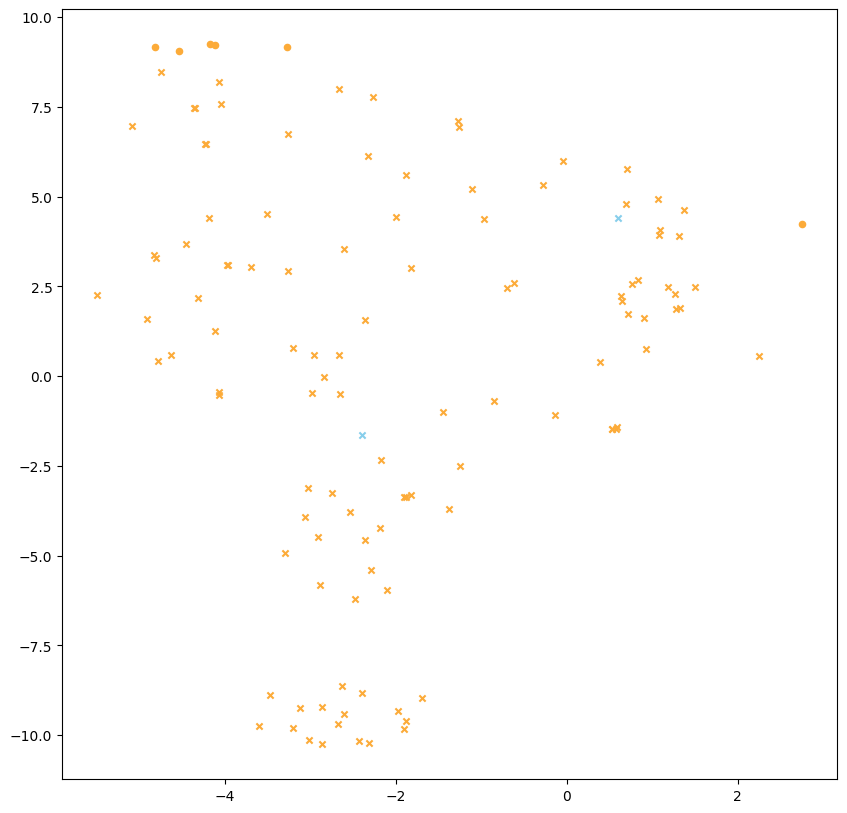

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=1, marker=marker)

# Set the background color to black
# plt.gca().set_facecolor('white')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.xlabel('Component 1', color='white')
# plt.ylabel('Component 2', color='white')

plt.show()


In [13]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [14]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [15]:
learning_rate = 1e-5
num_epochs = 450
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [16]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [17]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 150
epoch_loss_list = []
model_name = "FlakyXbert_IDoFT_project_binary_" + project_name + '_final.pth'
for epoch in range(num_epochs):
    total_loss = 0.0
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()

        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), model_name)
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    # The line `epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")` is attempting to append a formatted string to a list named `epoch_loss_list`. This string contains information about the current epoch number, total number of epochs, and the average loss calculated for that epoch. However, in the provided code snippet, the `epoch_loss_list` list is not defined or used anywhere else in the code.
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

 20%|██        | 3/15 [00:00<00:01,  9.64it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  6.99it/s]


Epoch 1/150, Loss: 1.0300996899604797


100%|██████████| 15/15 [00:02<00:00,  6.66it/s]


Epoch 2/150, Loss: 1.020656665166219


  7%|▋         | 1/15 [00:00<00:01,  8.39it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  7.90it/s]


Epoch 3/150, Loss: 0.9994895537694295


100%|██████████| 15/15 [00:02<00:00,  6.25it/s]


Epoch 4/150, Loss: 0.9977270642916362


  7%|▋         | 1/15 [00:00<00:02,  5.10it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


Epoch 5/150, Loss: 0.9810453255971273


100%|██████████| 15/15 [00:02<00:00,  5.74it/s]


Epoch 6/150, Loss: 0.9655791163444519


100%|██████████| 15/15 [00:02<00:00,  7.00it/s]


Epoch 7/150, Loss: 0.9562448302904765


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 8/150, Loss: 0.944281808535258


 13%|█▎        | 2/15 [00:00<00:01, 12.91it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  7.84it/s]


Epoch 9/150, Loss: 0.9212307572364807


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 10/150, Loss: 0.8945866386095683


100%|██████████| 15/15 [00:01<00:00,  7.76it/s]


Epoch 11/150, Loss: 0.8724486072858174


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


Epoch 12/150, Loss: 0.8430718779563904


  0%|          | 0/15 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


Epoch 13/150, Loss: 0.7986496965090434


 13%|█▎        | 2/15 [00:00<00:00, 13.87it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


Epoch 14/150, Loss: 0.7257866263389587


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch 15/150, Loss: 0.6835136115550995


  7%|▋         | 1/15 [00:00<00:02,  5.20it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  7.52it/s]


Epoch 16/150, Loss: 0.5522384464740753


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


Epoch 17/150, Loss: 0.529422237475713


100%|██████████| 15/15 [00:01<00:00,  7.53it/s]


Epoch 18/150, Loss: 0.413792230685552


100%|██████████| 15/15 [00:01<00:00,  7.53it/s]


Epoch 19/150, Loss: 0.449002742767334


  0%|          | 0/15 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Epoch 20/150, Loss: 0.28886712789535524


100%|██████████| 15/15 [00:02<00:00,  6.60it/s]


Epoch 21/150, Loss: 0.3472021738688151


 13%|█▎        | 2/15 [00:00<00:00, 15.53it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


Epoch 22/150, Loss: 0.29651612987120946


100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


Epoch 23/150, Loss: 0.28400091727574667


  0%|          | 0/15 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  6.25it/s]


Epoch 24/150, Loss: 0.26119850675264994


 13%|█▎        | 2/15 [00:00<00:00, 13.44it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


Epoch 25/150, Loss: 0.17576407777766387


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Epoch 26/150, Loss: 0.28586535503466926


100%|██████████| 15/15 [00:02<00:00,  5.84it/s]


Epoch 27/150, Loss: 0.2224091281493505


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 28/150, Loss: 0.2234135627746582


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 29/150, Loss: 0.20171475062767666


  7%|▋         | 1/15 [00:00<00:01,  7.20it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Epoch 30/150, Loss: 0.15011190623044968


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


Epoch 31/150, Loss: 0.22002822359402974


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Epoch 32/150, Loss: 0.15313217540582022


  7%|▋         | 1/15 [00:00<00:01,  8.63it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


Epoch 33/150, Loss: 0.20956523468097052


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 34/150, Loss: 0.2207673783103625


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Epoch 35/150, Loss: 0.16181449045737584


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


Epoch 36/150, Loss: 0.1635287900765737


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Epoch 37/150, Loss: 0.13674425035715104


  7%|▋         | 1/15 [00:00<00:01,  7.01it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  8.02it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 38/150, Loss: 0.1423445001244545


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


Epoch 39/150, Loss: 0.14918432732423145


  7%|▋         | 1/15 [00:00<00:01,  8.60it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Epoch 40/150, Loss: 0.13513755338887373


100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Epoch 41/150, Loss: 0.1543963871896267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 42/150, Loss: 0.0860279361406962


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch 43/150, Loss: 0.13111253281434376


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 44/150, Loss: 0.1187975786626339


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 45/150, Loss: 0.1391007532676061


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Epoch 46/150, Loss: 0.1263191188375155


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Epoch 47/150, Loss: 0.1462507501244545


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch 48/150, Loss: 0.12839511384566624


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch 49/150, Loss: 0.11158885012070338


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch 50/150, Loss: 0.10911243557929992


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


Epoch 51/150, Loss: 0.10742206623156865


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


Epoch 52/150, Loss: 0.08421549946069717


 13%|█▎        | 2/15 [00:00<00:05,  2.43it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Epoch 53/150, Loss: 0.08209298650423685


  7%|▋         | 1/15 [00:00<00:01,  8.26it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  9.00it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


Epoch 54/150, Loss: 0.08772695710261663


100%|██████████| 15/15 [00:02<00:00,  5.51it/s]


Epoch 55/150, Loss: 0.09254088898499807


  7%|▋         | 1/15 [00:00<00:01,  8.92it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 56/150, Loss: 0.09194684016207853


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 57/150, Loss: 0.07494824559738239


 13%|█▎        | 2/15 [00:00<00:03,  4.29it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 58/150, Loss: 0.10536074886719386


 13%|█▎        | 2/15 [00:00<00:02,  5.31it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.89it/s]


Epoch 59/150, Loss: 0.10887070621053378


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 60/150, Loss: 0.11940954426924387


  7%|▋         | 1/15 [00:00<00:02,  6.27it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  7.79it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


Epoch 61/150, Loss: 0.10382672796646754


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch 62/150, Loss: 0.0904716894030571


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


Epoch 63/150, Loss: 0.0675242637594541


 13%|█▎        | 2/15 [00:00<00:02,  5.42it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch 64/150, Loss: 0.12171555111805597


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch 65/150, Loss: 0.08535795162121455


  7%|▋         | 1/15 [00:00<00:12,  1.16it/s]

Loss improved saving model


 20%|██        | 3/15 [00:01<00:03,  3.00it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Epoch 66/150, Loss: 0.06606565415859222


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 67/150, Loss: 0.06782150566577912


  7%|▋         | 1/15 [00:00<00:02,  6.30it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  6.12it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


Epoch 68/150, Loss: 0.0903232833991448


  7%|▋         | 1/15 [00:00<00:02,  5.90it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


Epoch 69/150, Loss: 0.07531453669071198


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Epoch 70/150, Loss: 0.0704072559873263


 13%|█▎        | 2/15 [00:00<00:02,  5.43it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


Epoch 71/150, Loss: 0.08059295018513997


  7%|▋         | 1/15 [00:00<00:02,  6.15it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 72/150, Loss: 0.09349516779184341


100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


Epoch 73/150, Loss: 0.0701270212729772


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 74/150, Loss: 0.051224084571003914


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Epoch 75/150, Loss: 0.04866088132063548


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 76/150, Loss: 0.09503605167071025


  7%|▋         | 1/15 [00:00<00:02,  4.71it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


Epoch 77/150, Loss: 0.05351409415404002


 13%|█▎        | 2/15 [00:01<00:06,  1.93it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 78/150, Loss: 0.041276761889457704


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 79/150, Loss: 0.06316631302858393


  7%|▋         | 1/15 [00:00<00:02,  5.94it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch 80/150, Loss: 0.05128469318151474


  7%|▋         | 1/15 [00:00<00:02,  6.06it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  6.27it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:01,  6.09it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 81/150, Loss: 0.04911431769529979


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


Epoch 82/150, Loss: 0.08173490514357885


  7%|▋         | 1/15 [00:00<00:02,  5.70it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Epoch 83/150, Loss: 0.07627750933170319


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch 84/150, Loss: 0.06475141644477844


 13%|█▎        | 2/15 [00:00<00:03,  4.23it/s]

Loss improved saving model
Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  4.46it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 85/150, Loss: 0.06353257149457932


 13%|█▎        | 2/15 [00:01<00:06,  1.87it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.89it/s]


Epoch 86/150, Loss: 0.044573405385017396


 13%|█▎        | 2/15 [00:00<00:02,  5.56it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Epoch 87/150, Loss: 0.06923795541127523


  7%|▋         | 1/15 [00:00<00:02,  5.74it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


Epoch 88/150, Loss: 0.05202973795433839


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


Epoch 89/150, Loss: 0.04509464055299759


  7%|▋         | 1/15 [00:00<00:03,  4.47it/s]

Loss improved saving model


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


Epoch 90/150, Loss: 0.04157192707061767


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


Epoch 91/150, Loss: 0.04661204566558202


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


Epoch 92/150, Loss: 0.0661398967107137


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


Epoch 93/150, Loss: 0.04762362639109294


 13%|█▎        | 2/15 [00:00<00:02,  5.77it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 94/150, Loss: 0.030257012943426767


  7%|▋         | 1/15 [00:00<00:02,  6.15it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


Epoch 95/150, Loss: 0.05446773072083791


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


Epoch 96/150, Loss: 0.055170716842015584


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 97/150, Loss: 0.06192191044489543


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 98/150, Loss: 0.03250130613644918


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


Epoch 99/150, Loss: 0.04595689177513122


 13%|█▎        | 2/15 [00:00<00:05,  2.51it/s]

Loss improved saving model
Loss improved saving model


 20%|██        | 3/15 [00:01<00:03,  3.17it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


Epoch 100/150, Loss: 0.0313526913523674


 13%|█▎        | 2/15 [00:00<00:03,  3.84it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


Epoch 101/150, Loss: 0.023448271056016285


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Epoch 102/150, Loss: 0.029726784427960715


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 103/150, Loss: 0.03739752769470215


 13%|█▎        | 2/15 [00:00<00:03,  3.70it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Epoch 104/150, Loss: 0.05345792571703593


  7%|▋         | 1/15 [00:00<00:02,  5.95it/s]

Loss improved saving model


 20%|██        | 3/15 [00:01<00:04,  2.65it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 105/150, Loss: 0.05151921510696411


 13%|█▎        | 2/15 [00:00<00:02,  5.37it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Epoch 106/150, Loss: 0.04324702123800914


 13%|█▎        | 2/15 [00:00<00:02,  5.18it/s]

Loss improved saving model
Loss improved saving model


 27%|██▋       | 4/15 [00:01<00:04,  2.36it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 107/150, Loss: 0.04248940745989482


  7%|▋         | 1/15 [00:00<00:02,  5.87it/s]

Loss improved saving model


 20%|██        | 3/15 [00:01<00:06,  1.76it/s]

Loss improved saving model
Loss improved saving model


 33%|███▎      | 5/15 [00:02<00:03,  3.16it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 108/150, Loss: 0.046098293364048006


  7%|▋         | 1/15 [00:00<00:02,  6.02it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 109/150, Loss: 0.04370062599579493


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Epoch 110/150, Loss: 0.03545552417635918


 13%|█▎        | 2/15 [00:00<00:02,  5.45it/s]

Loss improved saving model


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Epoch 111/150, Loss: 0.03565271012485027


  7%|▋         | 1/15 [00:00<00:02,  5.32it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  5.17it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  5.46it/s]

Loss improved saving model


 33%|███▎      | 5/15 [00:01<00:03,  3.30it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Epoch 112/150, Loss: 0.0327213853597641


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


Epoch 113/150, Loss: 0.04244132786989212


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 114/150, Loss: 0.040697575608889265


  7%|▋         | 1/15 [00:00<00:01,  8.34it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


Epoch 115/150, Loss: 0.042817833522955574


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Epoch 116/150, Loss: 0.03471230566501617


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 117/150, Loss: 0.020054710904757182


  7%|▋         | 1/15 [00:00<00:01,  8.86it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  8.82it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:01,  8.55it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:00<00:01,  8.58it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


Epoch 118/150, Loss: 0.02876253624757131


  7%|▋         | 1/15 [00:00<00:01,  8.86it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  8.96it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  4.88it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:00<00:02,  4.10it/s]

Loss improved saving model


 40%|████      | 6/15 [00:01<00:01,  4.51it/s]

Loss improved saving model
Loss improved saving model


 47%|████▋     | 7/15 [00:01<00:01,  5.27it/s]

Loss improved saving model


 53%|█████▎    | 8/15 [00:02<00:02,  3.07it/s]

Loss improved saving model


 67%|██████▋   | 10/15 [00:02<00:01,  3.00it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


Epoch 119/150, Loss: 0.04537896811962128


  7%|▋         | 1/15 [00:00<00:01,  8.25it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  8.51it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  4.98it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 120/150, Loss: 0.02230964054663976


  7%|▋         | 1/15 [00:00<00:01,  8.14it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


Epoch 121/150, Loss: 0.024161918461322783


  7%|▋         | 1/15 [00:00<00:01,  9.06it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  9.40it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:01,  8.10it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 122/150, Loss: 0.0366121510664622


  7%|▋         | 1/15 [00:00<00:08,  1.64it/s]

Loss improved saving model


 20%|██        | 3/15 [00:01<00:03,  3.47it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


Epoch 123/150, Loss: 0.0294096772869428


  7%|▋         | 1/15 [00:00<00:02,  5.81it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  7.31it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:01<00:03,  3.14it/s]

Loss improved saving model
Loss improved saving model


 33%|███▎      | 5/15 [00:01<00:03,  3.10it/s]

Loss improved saving model


 47%|████▋     | 7/15 [00:02<00:02,  3.02it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Epoch 124/150, Loss: 0.042373061180114746


  7%|▋         | 1/15 [00:00<00:02,  5.96it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch 125/150, Loss: 0.026681519548098245


  7%|▋         | 1/15 [00:01<00:15,  1.08s/it]

Loss improved saving model


 13%|█▎        | 2/15 [00:01<00:09,  1.43it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:02<00:04,  2.38it/s]

Loss improved saving model
Loss improved saving model


 40%|████      | 6/15 [00:02<00:03,  2.80it/s]

Loss improved saving model
Loss improved saving model


 53%|█████▎    | 8/15 [00:03<00:01,  3.70it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 126/150, Loss: 0.03138243108987808


 13%|█▎        | 2/15 [00:01<00:07,  1.84it/s]

Loss improved saving model
Loss improved saving model


 27%|██▋       | 4/15 [00:01<00:03,  3.51it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 127/150, Loss: 0.031068100531895956


  7%|▋         | 1/15 [00:00<00:05,  2.40it/s]

Loss improved saving model


 20%|██        | 3/15 [00:01<00:06,  1.89it/s]

Loss improved saving model
Loss improved saving model


 27%|██▋       | 4/15 [00:01<00:04,  2.47it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Epoch 128/150, Loss: 0.03332375834385554


  7%|▋         | 1/15 [00:00<00:02,  6.15it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


Epoch 129/150, Loss: 0.023358582456906637


  7%|▋         | 1/15 [00:00<00:02,  6.03it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  6.18it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:01<00:02,  3.75it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


Epoch 130/150, Loss: 0.02459676464398702


 13%|█▎        | 2/15 [00:00<00:02,  5.43it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


Epoch 131/150, Loss: 0.029725315421819686


  7%|▋         | 1/15 [00:00<00:07,  1.91it/s]

Loss improved saving model


 20%|██        | 3/15 [00:01<00:03,  3.09it/s]

Loss improved saving model
Loss improved saving model


 33%|███▎      | 5/15 [00:01<00:02,  4.45it/s]

Loss improved saving model
Loss improved saving model


 40%|████      | 6/15 [00:01<00:01,  4.57it/s]

Loss improved saving model


 47%|████▋     | 7/15 [00:02<00:03,  2.36it/s]

Loss improved saving model


 60%|██████    | 9/15 [00:02<00:01,  3.38it/s]

Loss improved saving model
Loss improved saving model


 67%|██████▋   | 10/15 [00:03<00:01,  3.03it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


Epoch 132/150, Loss: 0.03236903448899587


  7%|▋         | 1/15 [00:00<00:02,  6.06it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:03,  3.85it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Epoch 133/150, Loss: 0.025149008631706236


  7%|▋         | 1/15 [00:00<00:11,  1.24it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


Epoch 134/150, Loss: 0.03721820612748464


  7%|▋         | 1/15 [00:00<00:02,  6.06it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  6.19it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  5.47it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:00<00:03,  3.66it/s]

Loss improved saving model


 40%|████      | 6/15 [00:01<00:01,  4.57it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch 135/150, Loss: 0.012914061546325684


  7%|▋         | 1/15 [00:00<00:02,  6.27it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch 136/150, Loss: 0.03789641857147217


  7%|▋         | 1/15 [00:00<00:02,  5.65it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  5.15it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:01<00:03,  3.03it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Epoch 137/150, Loss: 0.03314224084218343


 13%|█▎        | 2/15 [00:00<00:05,  2.31it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


Epoch 138/150, Loss: 0.0212079460422198


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


Epoch 139/150, Loss: 0.021147098143895468


  7%|▋         | 1/15 [00:00<00:02,  5.98it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  6.10it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:00<00:02,  5.49it/s]

Loss improved saving model
Loss improved saving model


 40%|████      | 6/15 [00:01<00:02,  4.32it/s]

Loss improved saving model
Loss improved saving model


 47%|████▋     | 7/15 [00:01<00:01,  4.48it/s]

Loss improved saving model


 60%|██████    | 9/15 [00:01<00:01,  4.84it/s]

Loss improved saving model
Loss improved saving model


 67%|██████▋   | 10/15 [00:02<00:01,  3.61it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


Epoch 140/150, Loss: 0.02752506484587987


  7%|▋         | 1/15 [00:00<00:02,  4.68it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Epoch 141/150, Loss: 0.014127732316652934


  7%|▋         | 1/15 [00:00<00:06,  2.21it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:04,  3.14it/s]

Loss improved saving model


 20%|██        | 3/15 [00:01<00:06,  1.83it/s]

Loss improved saving model


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 142/150, Loss: 0.028128880262374877


100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Epoch 143/150, Loss: 0.02988243798414866


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Epoch 144/150, Loss: 0.04663206338882446


 13%|█▎        | 2/15 [00:00<00:03,  3.48it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


Epoch 145/150, Loss: 0.029344583054383595


 13%|█▎        | 2/15 [00:01<00:05,  2.22it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Epoch 146/150, Loss: 0.0306863397359848


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


Epoch 147/150, Loss: 0.013229888677597047


  7%|▋         | 1/15 [00:00<00:02,  6.10it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  6.16it/s]

Loss improved saving model


 27%|██▋       | 4/15 [00:01<00:03,  2.75it/s]

Loss improved saving model
Loss improved saving model


 40%|████      | 6/15 [00:01<00:02,  3.95it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Epoch 148/150, Loss: 0.026315031945705412


  7%|▋         | 1/15 [00:00<00:02,  6.18it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  5.54it/s]

Loss improved saving model


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


Epoch 149/150, Loss: 0.025645269950230917


  7%|▋         | 1/15 [00:00<00:05,  2.51it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:01<00:08,  1.59it/s]

Loss improved saving model


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

Epoch 150/150, Loss: 0.01585754007101059


In [18]:
epoch_loss_list[-50:]

['Epoch 101/150, Loss: 0.023448271056016285',
 'Epoch 102/150, Loss: 0.029726784427960715',
 'Epoch 103/150, Loss: 0.03739752769470215',
 'Epoch 104/150, Loss: 0.05345792571703593',
 'Epoch 105/150, Loss: 0.05151921510696411',
 'Epoch 106/150, Loss: 0.04324702123800914',
 'Epoch 107/150, Loss: 0.04248940745989482',
 'Epoch 108/150, Loss: 0.046098293364048006',
 'Epoch 109/150, Loss: 0.04370062599579493',
 'Epoch 110/150, Loss: 0.03545552417635918',
 'Epoch 111/150, Loss: 0.03565271012485027',
 'Epoch 112/150, Loss: 0.0327213853597641',
 'Epoch 113/150, Loss: 0.04244132786989212',
 'Epoch 114/150, Loss: 0.040697575608889265',
 'Epoch 115/150, Loss: 0.042817833522955574',
 'Epoch 116/150, Loss: 0.03471230566501617',
 'Epoch 117/150, Loss: 0.020054710904757182',
 'Epoch 118/150, Loss: 0.02876253624757131',
 'Epoch 119/150, Loss: 0.04537896811962128',
 'Epoch 120/150, Loss: 0.02230964054663976',
 'Epoch 121/150, Loss: 0.024161918461322783',
 'Epoch 122/150, Loss: 0.0366121510664622',
 'Epo

In [19]:
siamese_network.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [20]:
siamese_network.to(device).eval()
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 119/119 [00:04<00:00, 25.38it/s]


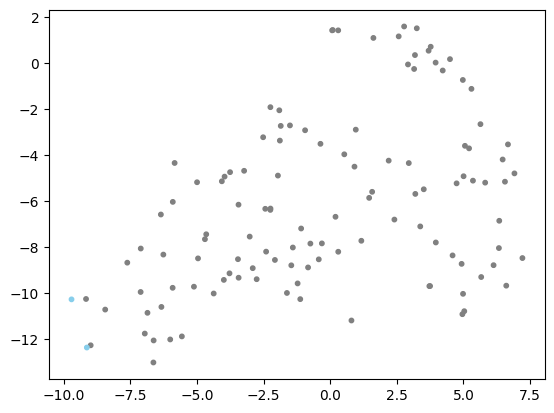

In [21]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap= cc , alpha=1 )


In [22]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=218, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [23]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 2
    for label in range(2):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [24]:
int_to_label={
    0: 'notFlaky',
    1: 'Flaky'
    }


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [25]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    


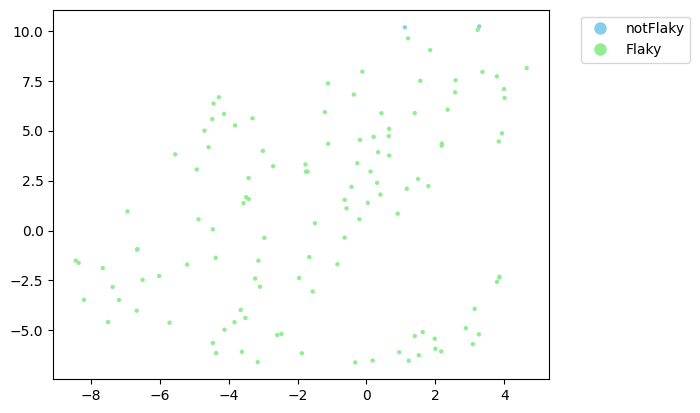

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed and post_train_label are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Ensure labels are within the range of colors [0, 1, 2, 3, 4]
# Filter out invalid labels (-1) and keep only valid labels [0, 1, 2, 3, 4]
valid_indices = [i for i, label in enumerate(labelsNums) if label in [0, 1]]
X_np_filtered = X_np[valid_indices]
labelsNums_filtered = [labelsNums[i] for i in valid_indices]

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np_filtered)

# Scatter plot
for i, label in enumerate(labelsNums_filtered):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
legend_labels = ['notFlaky', 'Flaky']
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels,bbox_to_anchor=(1.05, 1), 
                    loc='upper left')

plt.show()


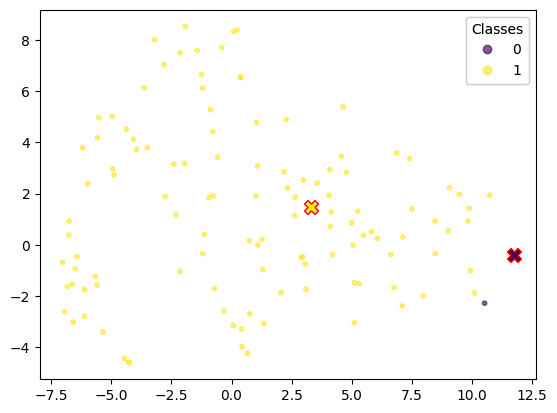

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [28]:
from sklearn.metrics import f1_score
# Create reverse mapping

count = 0

# Assuming val_dataset is iterable and has 'anchor' and 'label' keys
predicted_labels = []
true_labels = []

for item in val_dataset:
    count += 1
    input_vector = item['anchor']  # Your input vector for prediction
    
    # Get predicted cluster/label
    predicted_label_str = predict(input_vector)
    
    # Ensure predicted_label is in the valid range
    if predicted_label_str in label_to_int:
        predicted_label = label_to_int[predicted_label_str]
        predicted_labels.append(predicted_label)
    else:
        print(f"Warning: Encountered unknown predicted label {predicted_label_str}")
        continue

    # True label
    true_label_int = int(item['label'])  # Assuming 'label' contains the true label as integer
    if true_label_int in int_to_label:
        true_labels.append(true_label_int)
    else:
        print(f"Warning: Encountered unknown true label {true_label_int}")
        continue

    print(count, "Predicted:", predicted_label, "True:", true_label_int)

# Filter out any invalid entries where predicted or true labels are missing
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label and predicted_labels[i] in int_to_label]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

print("Loop completed")

# Calculate F1 Score, ignoring unknown labels
f1 = f1_score(filtered_true_labels, filtered_predicted_labels, average='weighted', zero_division=0)  # Adjust 'average' as necessary
print(f"F1 Score: {f1}")


1 Predicted: 1 True: 1
2 Predicted: 1 True: 1
3 Predicted: 1 True: 1
4 Predicted: 1 True: 1
5 Predicted: 1 True: 1
6 Predicted: 1 True: 1
7 Predicted: 1 True: 1
8 Predicted: 1 True: 1
9 Predicted: 1 True: 1
10 Predicted: 1 True: 1
11 Predicted: 1 True: 1
12 Predicted: 1 True: 1
13 Predicted: 1 True: 1
14 Predicted: 1 True: 1
15 Predicted: 1 True: 1
16 Predicted: 1 True: 1
17 Predicted: 1 True: 1
18 Predicted: 1 True: 1
19 Predicted: 1 True: 1
20 Predicted: 1 True: 1
21 Predicted: 1 True: 0
22 Predicted: 1 True: 1
23 Predicted: 1 True: 1
24 Predicted: 1 True: 1
25 Predicted: 1 True: 1
26 Predicted: 1 True: 1
27 Predicted: 1 True: 1
28 Predicted: 1 True: 1
29 Predicted: 1 True: 1
30 Predicted: 1 True: 1
Loop completed
F1 Score: 0.9502824858757062


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.97      1.00      0.98        29

    accuracy                           0.97        30
   macro avg       0.48      0.50      0.49        30
weighted avg       0.93      0.97      0.95        30


 - Accuracy :  0.97
 - Precision :  0.93
 - Recall :  0.97
 - F1 score :  0.95
 - MCC :  0.0
 - AUC :  0.5


Performances by categories



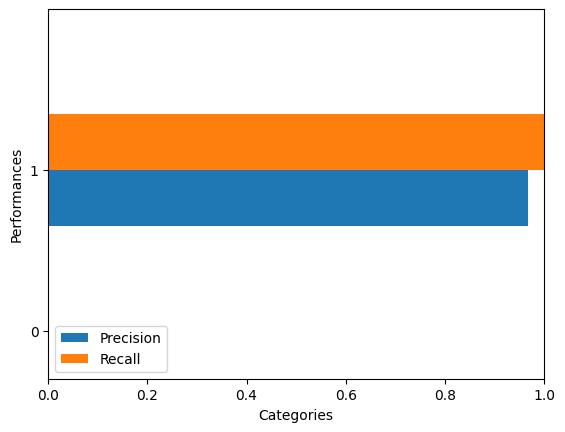



Confusion Matrix 


<AxesSubplot:>

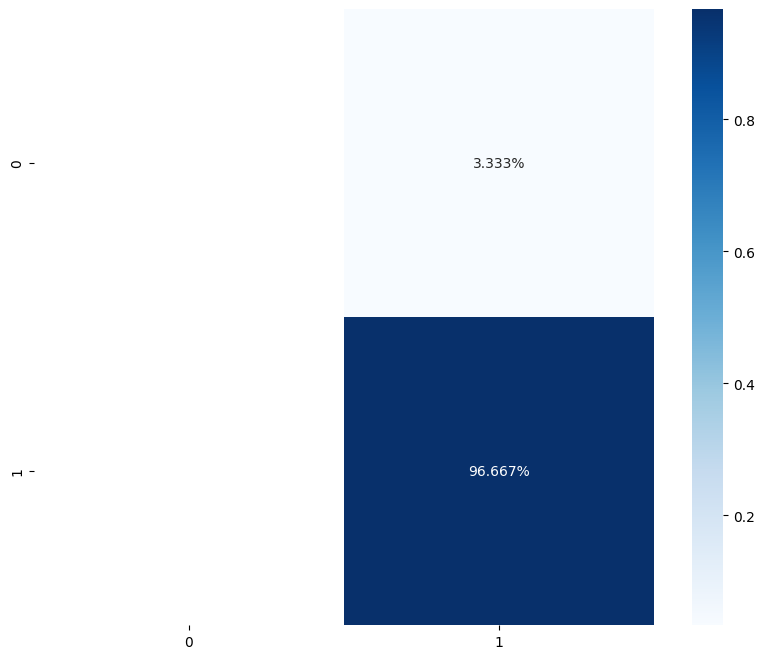

In [29]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore")

def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

# Assuming predicted_labels and true_labels are already defined
predicted = predicted_labels
labels = true_labels

# Filter out 'unknown' labels
valid_indices = [i for i, label in enumerate(labels) if label != 'unknown']
filtered_labels = [labels[i] for i in valid_indices]
filtered_predicted = [predicted[i] for i in valid_indices]

unique_labels = list(set(filtered_labels))
print(classification_report(filtered_labels, filtered_predicted))

print('\n - Accuracy : ', np.round(metrics.accuracy_score(filtered_labels, filtered_predicted), 2))
print(' - Precision : ', np.round(metrics.precision_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - Recall : ', np.round(metrics.recall_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - F1 score : ', np.round(metrics.f1_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - MCC : ', np.round(metrics.matthews_corrcoef(filtered_labels, filtered_predicted), 2))
print(' - AUC : ', np.round(multiclass_roc_auc_score(filtered_labels, filtered_predicted), 2))

print("\n\nPerformances by categories\n")

ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[0]
recall = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind, yticklabels=np.array(unique_labels), ylim=[2*width - 1, len(ind)])
plt.xlim(0, 1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(filtered_labels, filtered_predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index=[i for i in unique_labels], columns=[i for i in unique_labels])
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm / np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')


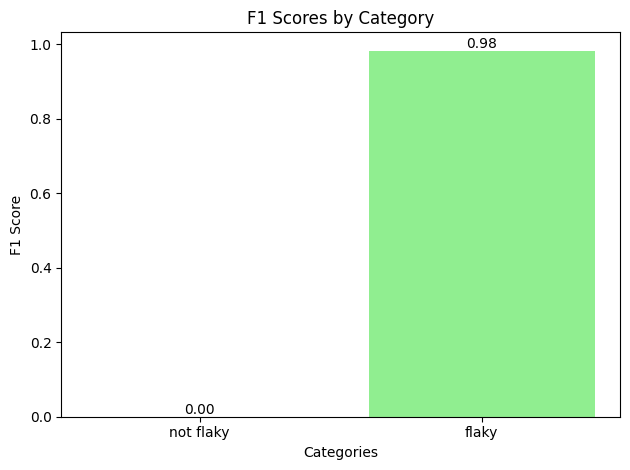

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
shortened_labels = {
    'notFlaky':'not flaky',
    'Flaky': 'flaky'
}
# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
# Filter out invalid labels from both true and predicted labels
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label.keys() and predicted_labels[i] in int_to_label.keys()]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.keys())
for category in categories:
    true_bin = [1 if label == category else 0 for label in filtered_true_labels]
    pred_bin = [1 if label == category else 0 for label in filtered_predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[int_to_label[category]] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
